In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
import LEN_Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
import copy
from torch.nn.functional import one_hot
import imblearn
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH


In [2]:
TH = TH()

mimicDF = TH.get_mimic()

mimicDF

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47083,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47084,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47085,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47086,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
mimicDF.describe()

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
count,47088.000000,47088.000000,484.000000,481.000000,705.000000,245.000000,31415.000000,31503.000000,31504.000000,8601.000000,...,12981.000000,14768.000000,14714.000000,4352.000000,2485.000000,32961.000000,85.000000,26516.000000,331.000000,2118.000000
mean,151079.910805,0.039755,630.123967,954.301455,67.382553,2.721633,77.058157,57.226709,117.544502,40.565399,...,33.217492,987.290546,1917.421073,96.799012,138.022942,97.267665,64.988235,37.235334,2.529305,12.747691
std,29378.613191,0.195386,1245.805613,2384.326867,5.448469,0.584693,14.324177,11.197415,21.311674,7.078312,...,10.474703,363.504762,608.801780,2.659592,5.435978,3.083466,10.518118,1.399548,3.004787,5.523420
min,100059.000000,0.000000,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,42.000000,1.210000,0.000000,43.000000,0.000000,0.000000,1.900000
25%,126241.000000,0.000000,25.000000,49.000000,64.000000,2.400000,68.000000,50.000000,103.000000,36.000000,...,26.168200,737.500000,1494.877533,96.000000,136.000000,96.000000,58.000000,36.900002,0.600000,9.000000
50%,151857.000000,0.000000,97.000000,137.000000,68.000000,2.700000,75.000000,56.000000,115.000000,40.000000,...,31.460699,931.028503,1841.049988,97.000000,138.000000,98.000000,65.000000,37.299999,1.400000,11.900000
75%,176484.000000,0.000000,554.750000,797.000000,70.000000,3.000000,84.000000,63.000000,129.000000,44.000000,...,38.118801,1169.229980,2244.340088,98.000000,140.000000,100.000000,71.000000,37.700001,3.300000,15.500000
max,199998.000000,1.000000,8100.000000,23060.000000,160.000000,4.400000,287.000000,191.000000,255.000000,91.000000,...,179.212997,3784.620117,6000.000000,100.000000,164.000000,100.000000,100.000000,46.500000,16.400000,48.300000


In [4]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [71]:
# for id in mimicDF['PatientID'].unique()[:1]:
#     patientDF = mimicDF[mimicDF['PatientID'] == id]
#     display(patientDF)

In [5]:


patients = TH.get_patients()

print(len(patients))

1126


In [70]:
print(patients[0].patientID, '\n', patients[0].data)

178177 
     Mortality14Days  ALT  AST  Admit Ht  Albumin  Arterial BP Mean  \
0                 0  NaN  NaN       NaN      NaN               NaN   
1                 0  NaN  NaN       NaN      NaN               NaN   
2                 0  NaN  NaN       NaN      NaN               NaN   
3                 0  NaN  NaN       NaN      NaN               NaN   
4                 0  NaN  NaN       NaN      NaN               NaN   
5                 0  NaN  NaN       NaN      NaN               NaN   
6                 0  NaN  NaN       NaN      NaN               NaN   
7                 0  NaN  NaN       NaN      NaN               NaN   
8                 0  NaN  NaN       NaN      NaN               NaN   
9                 0  NaN  NaN       NaN      NaN               NaN   
10                0  NaN  NaN       NaN      NaN               NaN   
11                0  NaN  NaN       NaN      NaN               NaN   
12                0  NaN  NaN       NaN      NaN               NaN   
13         

In [95]:
nullCount = {}



for patient in patients:

    for column in patient.data.columns:

        if patient.data[column].isnull().all():

            if column not in nullCount:
                nullCount[column] = int(patient.data[column].isnull().all())
            else:
                nullCount[column] += int(patient.data[column].isnull().all())

nullCount = dict(sorted(nullCount.items(), key=lambda item: item[1]))


display(nullCount)


{'Platelets': 25,
 'Arterial BP [Diastolic]': 29,
 'Arterial BP [Systolic]': 29,
 'Arterial BP Mean': 30,
 'CVP': 36,
 'Arterial pH': 43,
 'Hemoglobin': 45,
 'Arterial PaCO2': 51,
 'Arterial PaO2': 51,
 'SVR': 57,
 'Ionized Calcium': 73,
 'SVRI': 77,
 'SVI': 123,
 'Resp Rate (Spont)': 219,
 'SaO2': 232,
 'CaO2': 313,
 'Potassium': 381,
 'Glucose': 382,
 'Sodium': 384,
 'BUN': 388,
 'Creatinine': 388,
 'Chloride': 389,
 'WBC': 395,
 'Daily Weight': 408,
 'INR': 442,
 'PTT': 444,
 'Magnesium': 445,
 'Admit Ht': 463,
 'NBP [Systolic]': 501,
 'NBP [Diastolic]': 516,
 'NBP Mean': 519,
 'Fibrinogen': 795,
 'ALT': 873,
 'AST': 876,
 'Total Bili': 955,
 'Albumin': 983,
 'LDH': 991,
 'SvO2': 1077,
 'Respiratory Rate (spontaneous)': 1125}

Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP']
False
False
False
False
False


In [113]:

patientsKept = []


for i in range(len(patient.data.columns)):

    columnsToKeep = list(nullCount.keys())[:i]

    print(f"Keeping {columnsToKeep}")

    nonNullPatients = []

    for patient in patients:

        for col in columnsToKeep:

            if patient.data[col].isnull().all():
                break
        
        else:
            nonNullPatients.append(patient)

    # nonNullPatients = [patient for patient in patients if not patient.data[columnsToKeep].isnull().all().all()]


    print(len(nonNullPatients))

    patientsKept.append(len(nonNullPatients))

print(patientsKept)

# display(patients[0].data[columnsToKeep])

Keeping []
1126
Keeping ['Platelets']
1101
Keeping ['Platelets', 'Arterial BP [Diastolic]']
1076
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]']
1076
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean']
1075
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP']
1057
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP', 'Arterial pH']
1044
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP', 'Arterial pH', 'Hemoglobin']
1024
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP', 'Arterial pH', 'Hemoglobin', 'Arterial PaCO2']
1018
Keeping ['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]', 'Arterial BP Mean', 'CVP', 'Arterial pH', 'Hemoglobin', 'Arterial PaCO2', 'Arterial PaO2']
1018
Keeping ['Platelets', 'Arterial B

In [ ]:
patientsKeptDF = pd.DataFrame(data=patientsKept)

patientsKeptDF

In [78]:
# columnsToInterpolate = ['Glucose']

noInterpolation = 0

for patient in patients[:1]:

    try:
        print(patient.data.isnull().all())
        patient.interpolatedData = patient.data[patient.data.columns[1:]].apply(lambda x: x.interpolate(method='polynomial', order=3, limit_direction='both'))
        patient.interpolatedData = patient.interpolatedData.apply(lambda x: x.interpolate(method='linear', limit_direction='both', fill_value='extrapolate'))
   
    except ValueError:
        patient.interpolatedData = patient.data.apply(lambda x: x.fillna(x.mean()))
        noInterpolation += 1
        continue

# Is this true?
print(f"{noInterpolation}/{len(patients)} patients have no missing values")

ALT                                True
AST                                True
Admit Ht                          False
Albumin                            True
Arterial BP Mean                  False
Arterial BP [Diastolic]           False
Arterial BP [Systolic]            False
Arterial PaCO2                    False
Arterial PaO2                     False
Arterial pH                       False
BUN                               False
CVP                               False
CaO2                               True
Chloride                          False
Creatinine                        False
Daily Weight                       True
Fibrinogen                        False
Glucose                           False
Heart Rate                        False
Hemoglobin                        False
INR                               False
Ionized Calcium                   False
LDH                                True
Magnesium                         False
NBP Mean                          False


In [77]:
print(patients[0].interpolatedData)

    ALT  AST  Admit Ht  Albumin  Arterial BP Mean  Arterial BP [Diastolic]  \
0   NaN  NaN      65.0      NaN         81.538462                     64.0   
1   NaN  NaN      65.0      NaN         81.538462                     64.0   
2   NaN  NaN      65.0      NaN         81.538462                     64.0   
3   NaN  NaN      65.0      NaN         81.538462                     64.0   
4   NaN  NaN      65.0      NaN         81.538462                     64.0   
5   NaN  NaN      65.0      NaN         81.538462                     64.0   
6   NaN  NaN      65.0      NaN         81.538462                     64.0   
7   NaN  NaN      65.0      NaN         81.538462                     64.0   
8   NaN  NaN      65.0      NaN         81.538462                     64.0   
9   NaN  NaN      65.0      NaN         81.538462                     64.0   
10  NaN  NaN      65.0      NaN         81.538462                     64.0   
11  NaN  NaN      65.0      NaN         81.538462               

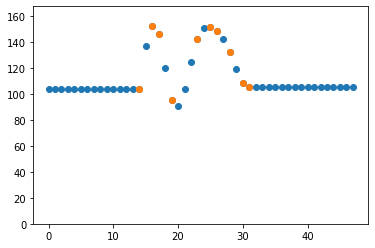

In [61]:
glucoseSeries = patients[0].interpolatedData[columnsToInterpolate[0]]

plt.ylim(1.1*min(0, min(glucoseSeries)), 1.1*max(max(glucoseSeries), max(patients[0].data[columnsToInterpolate[0]])))
plt.scatter(glucoseSeries.index, glucoseSeries)

plt.scatter(patients[0].data.index, patients[0].data[columnsToInterpolate[0]])


plt.show()

In [63]:
dataDF = pd.DataFrame([patient.interpolatedData['Glucose'].values for patient in patients]).fillna(patient.interpolatedData["Glucose"].mean())

data = dataDF.to_numpy()

dataFormatted = to_time_series_dataset([*data])

# dataFormatted = TimeSeriesScalerMeanVariance().fit_transform(data)

print(data.shape)
print(dataFormatted.shape)


(1126, 48)
(1126, 48, 1)


In [64]:

clusters = 10

model = TimeSeriesKMeans(n_clusters=clusters, metric="dtw", max_iter=200, random_state=0)
y_pred = model.fit_predict(dataFormatted)

print(silhouette_score(data, y_pred))



0.2204492190579948


0.2204492190579948


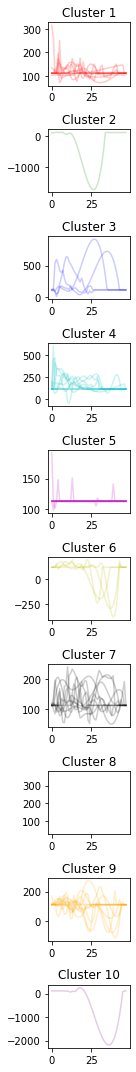

In [65]:
colours = {0:'r', 1:'g', 2:'b', 3:'c', 4:'m', 5:'y', 6:'k', 7:'w', 8:'orange', 9:'purple', 10:'pink'}


fig = plt.figure(figsize=(2,15))

for i in range(clusters):
    plt.subplot(clusters, 1, i+1)
    for sample in dataFormatted[y_pred == i][:10]:
        plt.plot(sample, c=colours[i], alpha=0.2)
    plt.title(f"Cluster {i+1}")

plt.tight_layout()

print(silhouette_score(data, y_pred))